In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from IPython.display import clear_output
import torch
import matplotlib.pyplot as plt

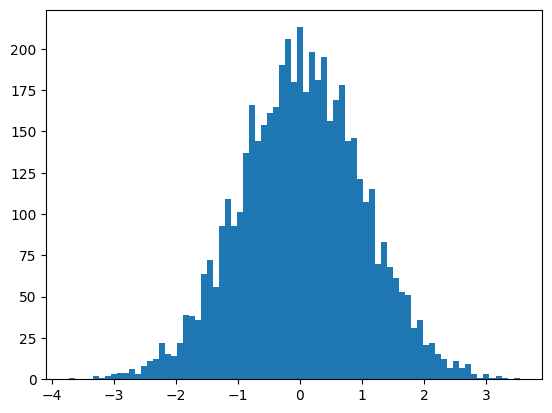

In [2]:
prior = torch.distributions.MultivariateNormal(torch.zeros(1), torch.eye(1))

N_D = 5000
multiplicity = 100

D_theta = prior.sample([N_D])
D_x = D_theta + torch.randn(N_D, multiplicity)
plt.hist(D_theta.numpy(), bins = 75)
plt.show()

In [3]:
N_obs = 100
sigma_misspecification = 2
theta_obs= prior.sample([N_obs])
N_per_obs = 1
x0_obs=[]
for theta in theta_obs: 
    x0_obs.append(theta + torch.randn(N_per_obs, multiplicity)*(1+sigma_misspecification))
x0_obs = torch.stack(x0_obs)

In [4]:
from conditional_density_estimation import * 
dif = ConditionalDIF(D_x, D_theta, 10,[64,64])
dif.train(100,1000, lr = 5e-3, verbose = True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s, loss = 137.769058 ; device: cpu]


In [5]:
#Generate well specified observation
theta_test = torch.tensor([0.])
print(theta_test[0])
x0_test = theta_test + torch.randn(N_per_obs, multiplicity)
print(x0_test.shape)

tensor(0.)
torch.Size([1, 100])


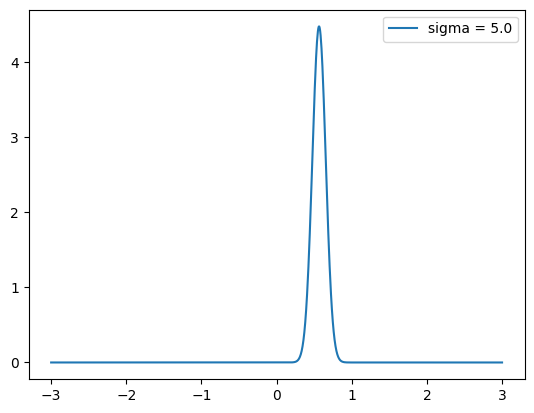

In [14]:
from markov_chain_monte_carlo import * 
tt = torch.linspace(-3,3,1000)
with torch.no_grad():
    for sigma in torch.linspace(0,5,5):
        noisy_x0 = x0_test + sigma*torch.randn_like(x0_test)
        posterior_log_prob = lambda theta: prior.log_prob(theta) + torch.sum(dif.log_prob(noisy_x0.unsqueeze(0).repeat(theta.shape[0],1,1), theta.unsqueeze(1).repeat(1, noisy_x0.shape[0],1)), dim= 1)
        #samples = IndependentMetropolisHastings(posterior_log_prob,1, prior, 5000).sample(200)
        #plt.hist(samples.numpy(), bins = 75, density= True)
        
        sigma2_n = (sigma**2 + 1 + multiplicity*N_per_obs)**(-1)
        mu_n = sigma2_n*(torch.sum(noisy_x0))
        true_posterior= torch.distributions.MultivariateNormal(torch.tensor([mu_n]), torch.tensor([[sigma2_n]]))
        plt.plot(tt, torch.exp(true_posterior.log_prob(tt.unsqueeze(-1))), label ='sigma = '+ str(sigma.item()))
        plt.legend()
        plt.show()
        clear_output(wait= True)

In [80]:
ratio = NeuralLikelihoodRatio(D_x, D_theta,[64,64])
ratio.train(100, lr = 5e-3, verbose = True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.18it/s, loss = 6174.429688; device =cpu]


In [81]:
#Generate well specified observation
theta_test = torch.tensor([0.])
print(theta_test[0])
x0_test = theta_test + torch.randn(multiplicity)
print(x0_test.shape)

tensor(0.)
torch.Size([100])


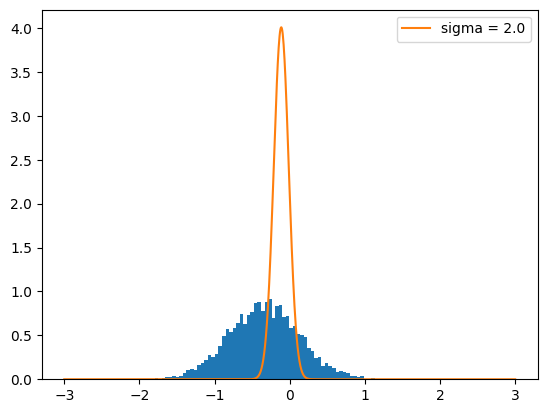

In [83]:
tt = torch.linspace(-3,3,1000)
with torch.no_grad():
    for sigma in torch.linspace(0,2,2):
        noisy_x0 = x0_test + sigma*torch.randn_like(x0_test)
        posterior_log_prob = lambda theta: prior.log_prob(theta) + ratio.log_ratio(noisy_x0.unsqueeze(0).repeat(theta.shape[0],1), theta)
        samples = IMH(posterior_log_prob,1, prior, 5000).sample(200)
        plt.hist(samples.numpy(), bins = 75, density= True)
        
        sigma2_n = (1 + multiplicity*N_per_obs)**(-1)
        mu_n = sigma2_n*(torch.sum(noisy_x0))
        true_posterior= torch.distributions.MultivariateNormal(torch.tensor([mu_n]), torch.tensor([[sigma2_n]]))
        plt.plot(tt, torch.exp(true_posterior.log_prob(tt.unsqueeze(-1))), label ='sigma = '+ str(sigma.item()))
        plt.legend()
        plt.show()
        clear_output(wait= True)